## Importing all the necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)

# Input df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [2]:
!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py

--2024-11-18 21:02:16--  https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13881 (14K) [text/plain]
Saving to: ‘helper_prabowo_ml.py’

helper_prabowo_ml.p 100%[===================>]  13.56K  --.-KB/s    in 0.003s  

2024-11-18 21:02:16 (5.00 MB/s) - ‘helper_prabowo_ml.py’ saved [13881/13881]



In [3]:
!pip install transformers

In [4]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the train, validation and test datasets

In [5]:
train = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

## Combining the train, validation and test datasets into a single dataframe

In [6]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,Sentiment
0,11938,i had to cut the lines to make it fit making i...,fear
1,12792,i began to feel sympathetic for khezef but i w...,love
2,7235,i can feel accepted,joy
3,11638,i feel carefree and young and amazing,joy
4,768,im feeling lousy i may dismiss a gorgeous day ...,sadness


In [7]:
df.drop('index',axis=1,inplace=True)

In [8]:
df.shape

(2000, 2)

## Text Preprocessing

In [9]:
def preprocess_data(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data

In [10]:
preprocessed_df = preprocess_data(df,'Input')
preprocessed_df.head()

,Input,Sentiment
0,cut lines make fit making sound bit rushed let...,fear
1,began feel sympathetic khezef sure right,love
2,feel accepted,joy
3,feel carefree young amazing,joy
4,m feeling lousy may dismiss gorgeous day im fe...,sadness


In [11]:
preprocessed_df['num_words'] = preprocessed_df.Input.apply(len)

In [12]:
preprocessed_df.head()

,Input,Sentiment,num_words
0,cut lines make fit making sound bit rushed let...,fear,124
1,began feel sympathetic khezef sure right,love,40
2,feel accepted,joy,13
3,feel carefree young amazing,joy,27
4,m feeling lousy may dismiss gorgeous day im fe...,sadness,97


In [13]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 

## Train-Test Split

In [14]:
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.Sentiment)

## Loading the Tokenizer class and pretrained BERT model

In [15]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


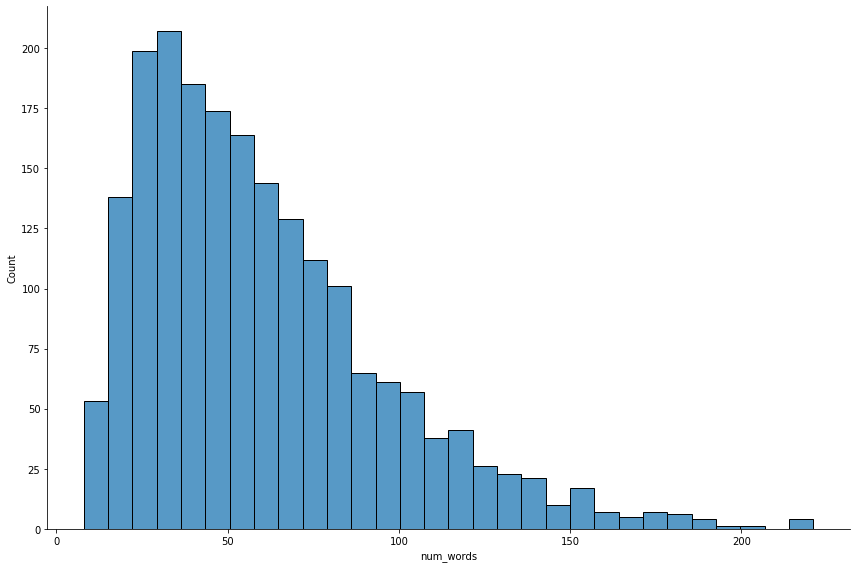

In [16]:
sns.displot(preprocessed_df.num_words,height=8,aspect=1.5)

In [17]:
max_len = 40

## Text Tokenization

In [18]:
tokenizer(text='So Dick , how about getting some coffee for tonight aaaaaaaaa kifech ?',
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

{'input_ids': <tf.Tensor: shape=(1, 40), dtype=int32, numpy=
array([[  101,  2061,  5980,  1010,  2129,  2055,  2893,  2070,  4157,
         2005,  3892, 13360, 11057, 11057, 11057, 11382,  7959,  2818,
         1029,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 40), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>}

In [19]:
X_train = tokenizer(text=train_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

## Defining the model architecture

In [20]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)

In [21]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=6,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

## Compiling the model

In [22]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=Adam(learning_rate=5e-5,epsilon=1e-8,decay=0.01,clipnorm=1.0),
              metrics=CategoricalAccuracy('balanced_accuracy'))

## Encoding the emotion labels

In [23]:
train_data['Label'] = train_data.Sentiment.map(encoded_labels)
test_data['Label'] = test_data.Sentiment.map(encoded_labels)

In [24]:
train_data.head()

,Input,Sentiment,num_words,Label
1701,started feeling amazing,joy,23,2
775,feel respected work though,joy,26,2
293,feel repressed enough sorts repressive measure...,sadness,117,4
133,feel guilt inaction spend much time helping su...,joy,61,2
243,m trying intuitive often makes feel sort confu...,fear,58,1


In [25]:
test_data.head()

,Input,Sentiment,num_words,Label
1485,really feel happen lifetime still working publ...,love,86,3
514,feel particularly delighted,joy,27,2
22,m attracted feel knows hes weird weirdo figure...,surprise,63,5
1710,feeling pretty low despite wettest summer rec,sadness,45,4
112,sit deck soak warmth sun sometimes feels ok wo...,joy,76,2


## Generating the model summary and plot

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 40)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]          

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


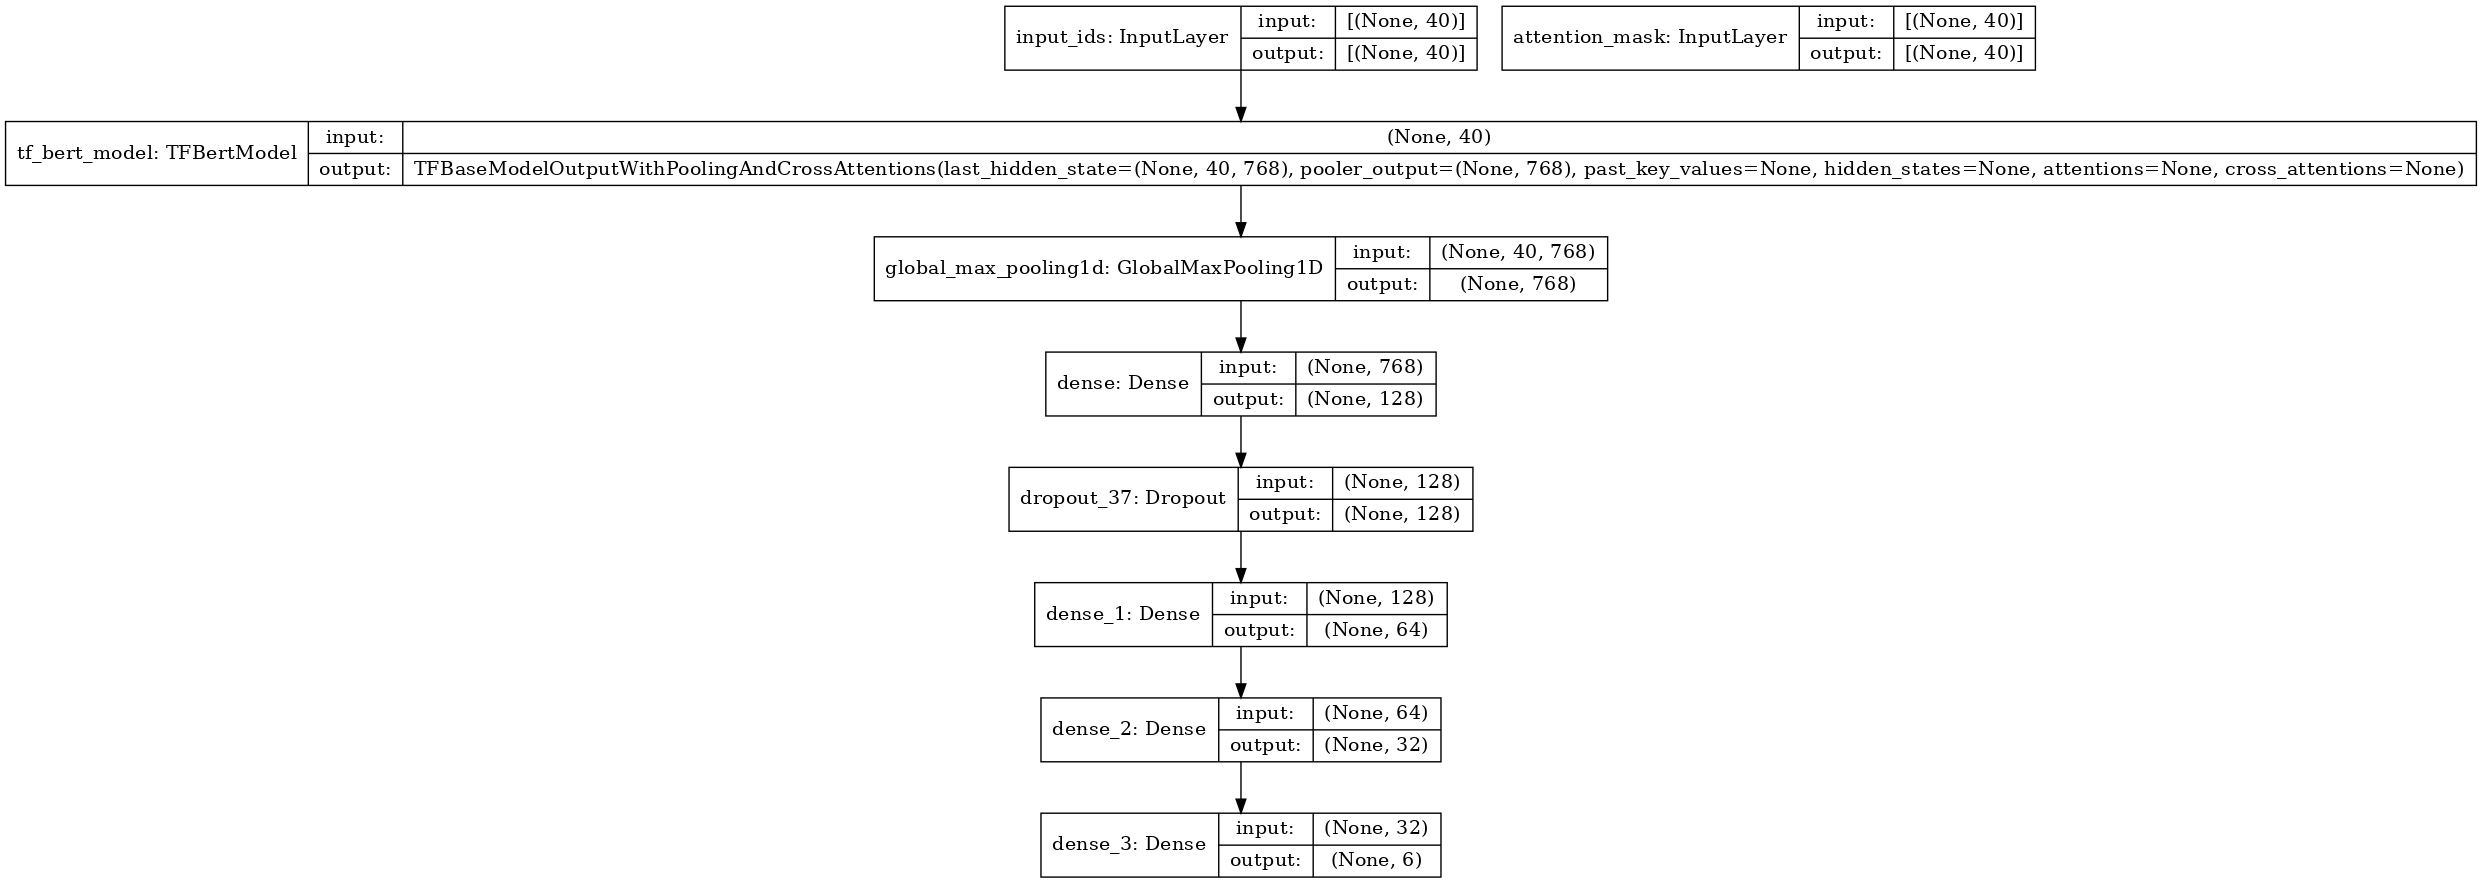

In [27]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

## Training and fine-tuning the pretrained BERT model 

In [28]:
X_train['input_ids'],X_train['attention_mask']

(<tf.Tensor: shape=(1400, 40), dtype=int32, numpy=
 array([[  101,  2318,  3110, ...,     0,     0,     0],
        [  101,  2514,  9768, ...,     0,     0,     0],
        [  101,  2514, 16360, ...,     0,     0,     0],
        ...,
        [  101,  2215,  2360, ...,     0,     0,     0],
        [  101,  1049,  2425, ...,     0,     0,     0],
        [  101,  2514,  2540, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(1400, 40), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>)

In [29]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=10,
             batch_size=32,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
             )

Epoch 1/10
44/44 [==============================] - 351s 7s/step - loss: 1.5600 - balanced_accuracy: 0.3793 - val_loss: 1.3580 - val_balanced_accuracy: 0.5367
Epoch 2/10
44/44 [==============================] - 316s 7s/step - loss: 1.1599 - balanced_accuracy: 0.5871 - val_loss: 0.9269 - val_balanced_accuracy: 0.6667
Epoch 3/10
44/44 [==============================] - 316s 7s/step - loss: 0.7452 - balanced_accuracy: 0.7457 - val_loss: 0.5951 - val_balanced_accuracy: 0.7900
Epoch 4/10
44/44 [==============================] - 317s 7s/step - loss: 0.4254 - balanced_accuracy: 0.8650 - val_loss: 0.4354 - val_balanced_accuracy: 0.8500
Epoch 5/10
44/44 [==============================] - 317s 7s/step - loss: 0.2297 - balanced_accuracy: 0.9279 - val_loss: 0.4315 - val_balanced_accuracy: 0.8750
Epoch 6/10
44/44 [==============================] - 317s 7s/step - loss: 0.1343 - balanced_accuracy: 0.9614 - val_loss: 0.4264 - val_balanced_accuracy: 0.8700
Epoch 7/10
44/44 [============================

## Analyzing model performance

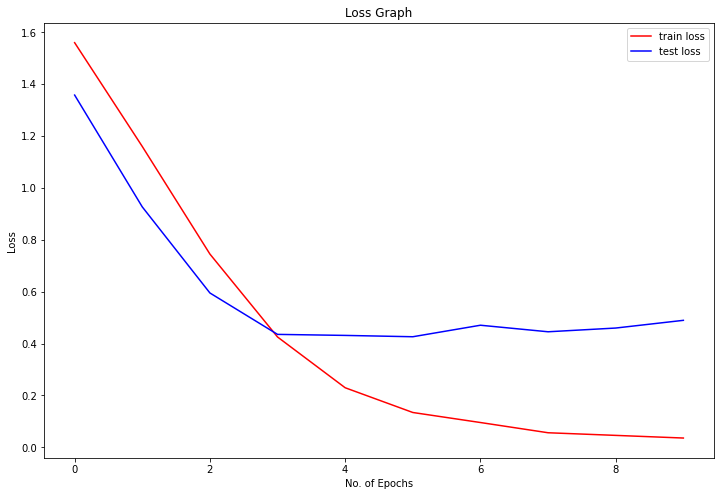

In [30]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

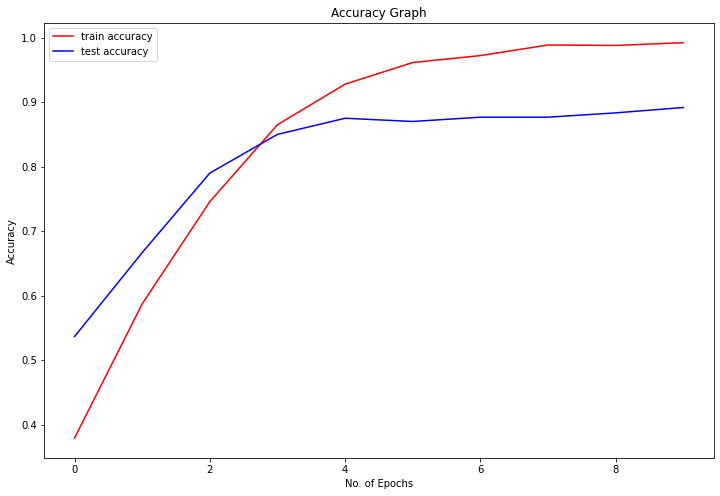

In [31]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [32]:
model.save("emotion_detector.h5")

## Evaluating the model on the test dataset

In [33]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

19/19 [==============================] - 44s 2s/step - loss: 0.4896 - balanced_accuracy: 0.8917
Test Categorical Cross-Entropy Loss: 0.4896160364151001
Test Categorical Accuracy: 0.8916666507720947


In [34]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89        76
           1       0.83      0.91      0.87        68
           2       0.90      0.93      0.91       210
           3       0.79      0.59      0.68        44
           4       0.97      0.90      0.93       184
           5       0.79      0.83      0.81        18

    accuracy                           0.89       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.89      0.89      0.89       600



The result is quite promising as we've obtained an excellent f1-score of almost 80% for all the 6 emotion classes.